Version notes: First combination test

Prerequisites: Create single category combine cards with the RunCombine_singleCategory.ipynb

In [1]:
fit_real_data = False
runCombine = True
runImpacts = True
version = 'v0'

In [2]:
card_name = 'combination'
if not fit_real_data: card_name += 'Asimov'
card_name += '_'+version

SM_RDst = 0.33

# Import

In [3]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import commands
from prettytable import PrettyTable
import json, yaml
from IPython.display import IFrame, Image, display

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory
from progressBar import ProgressBar
from combine_utilities import getUncertaintyFromLimitTree, dumpDiffNuisances, stringJubCustomizationCaltechT2

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if fit_real_data:
    CMS_lumi.extraText = "     Preliminary"
else:
    CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Load the cards

In [5]:
processOrder = ['tau', 'mu', 'DstPip','DstPi0','DstPipPi0','DstPipPim','DstPi0Pi0','DstmDsp','DstmD0','DstmDp','BpDstmHc','BmDstmHc','antiB0DstmHc']

In [6]:
categoriesList = ['low', 'mid', 'high']

In [7]:
version_singleCard = 'v9'
ct = 'cards/'+version_singleCard
if not fit_real_data: ct += 'Asimov'

cardLoc_sCat = {}
card_sCat = {}
for c in categoriesList:
    cardLoc_sCat[c] = ct + '_' + c + '.txt'
    with open(cardLoc_sCat[c], 'r') as f:
        card_sCat[c] = f.read()

In [8]:
expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4} #fb^-1

# Create combination card

In [9]:
card_location = 'cards/' + card_name + '.txt'
cmd = 'cd cards; '
cmd += 'combineCards.py'
for c in categoriesList:
    cmd += ' {}={}'.format(c, cardLoc_sCat[c].replace('cards/', ''))
cmd += ' > ' + card_name + '.txt'
print cmd
if os.system(cmd): raise

cd cards; combineCards.py low=v9Asimov_low.txt mid=v9Asimov_mid.txt high=v9Asimov_high.txt > combinationAsimov_v0.txt


In [10]:
with open(card_location) as f:
    print f.read()

Combination of low=v9Asimov_low.txt  mid=v9Asimov_mid.txt  high=v9Asimov_high.txt
imax 42 number of bins
jmax 12 number of processes minus 1
kmax 34 number of nuisance parameters
----------------------------------------------------------------------------------------------------------------------------------
shapes *                    high_AddTk_m_mHad    /storage/user/ocerri/BPhysics/data/_root/histos4combine/v9Asimov_high_AddTk_m_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes *                    high_AddTk_mm_mHad   /storage/user/ocerri/BPhysics/data/_root/histos4combine/v9Asimov_high_AddTk_mm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes *                    high_AddTk_p_mHad    /storage/user/ocerri/BPhysics/data/_root/histos4combine/v9Asimov_high_AddTk_p_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes *                    high_AddTk_pm_mHad   /storage/user/ocerri/BPhysics/data/_root/histos4combine/v9Asimov_high_AddTk_pm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes *        

In [11]:
outdir = 'results/' + card_name
if os.path.isdir(outdir) and runCombine:
    os.system('rm -rf ' + outdir)
os.system('mkdir -p ' + outdir + '/fig')

0

## Create the workspace

In [12]:
cmd = 'text2workspace.py ' + card_location 
cmd += ' -o ' + card_location.replace('.txt', '.root')
cmd += ' --no-b-only'
cmd += ' --verbose 1'
# cmd += ' --no-wrappers'
if os.system(cmd): raise

Channel low_AddTk_m_mHad will use autoMCStats with settings: event-threshold=5, include-signal=1, hist-mode=1
Analysing bin errors for: prop_binlow_AddTk_m_mHad
Poisson cut-off: 5
Bin        Contents        Error           Notes                         
0          13.023741       1.573630        total sum                     
0          68.000000       8.246211        Unweighted events, alpha=0.191526
  => Total parameter prop_binlow_AddTk_m_mHad_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          322.402461      7.530195        total sum                     
1          1833.000000     42.813549       Unweighted events, alpha=0.175888
  => Total parameter prop_binlow_AddTk_m_mHad_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
2          493.535735      9.264524        total sum                     
2          2838.000000     53.272882       Unweighted even

Creating pdfs for individual modes (42): .    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.   37.   38.   39.   40.   41.   42done.
Importing combined pdf model_s


# Pre-fit plots

In [13]:
binning = {}
if fit_real_data:
    binning['q2'] = array('d', [-2, 2.5, 6])
else:
    binning['q2'] = array('d', [-2, 2.5, 6, 9.4, 12])

Load the histograms

In [14]:
histo = {}
fAux = {}
for c in categoriesList:
    histo[c] = {}
    fAux[c] = {}
    for line in card_sCat[c].split(60*'-'+'\n')[1][:-1].split('\n'):
        line = line.split(' ')
        k = line[2]
        histo[c][k] = {}
        loc = line[3]
        fAux[c][k] = rt.TFile.Open(loc, 'READ')
        for o in fAux[c][k].GetListOfKeys():
            n = o.GetName()
            if '__' in n:
                continue
            histo[c][k][n.replace('_obs', '')] = fAux[c][k].Get(n).Clone()

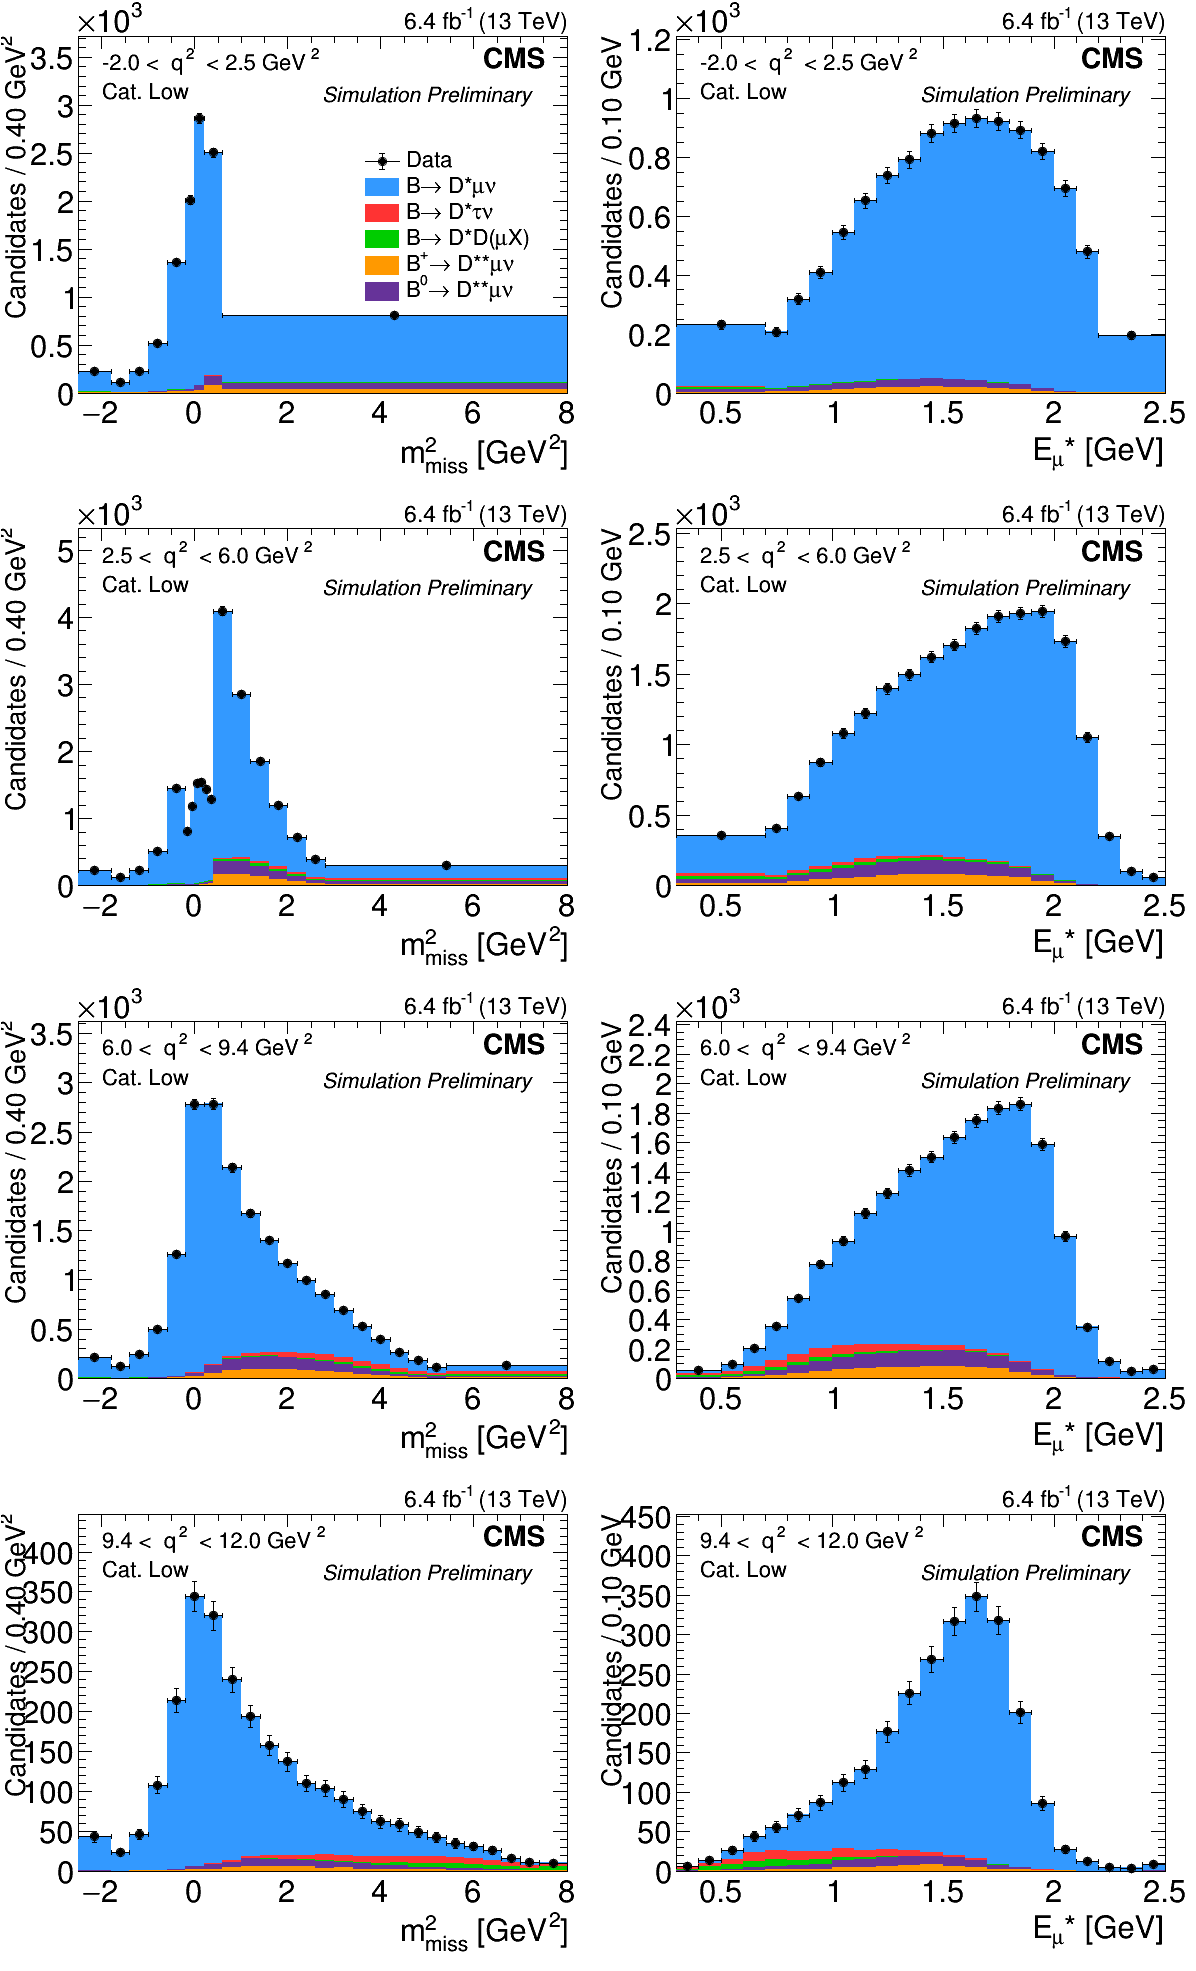

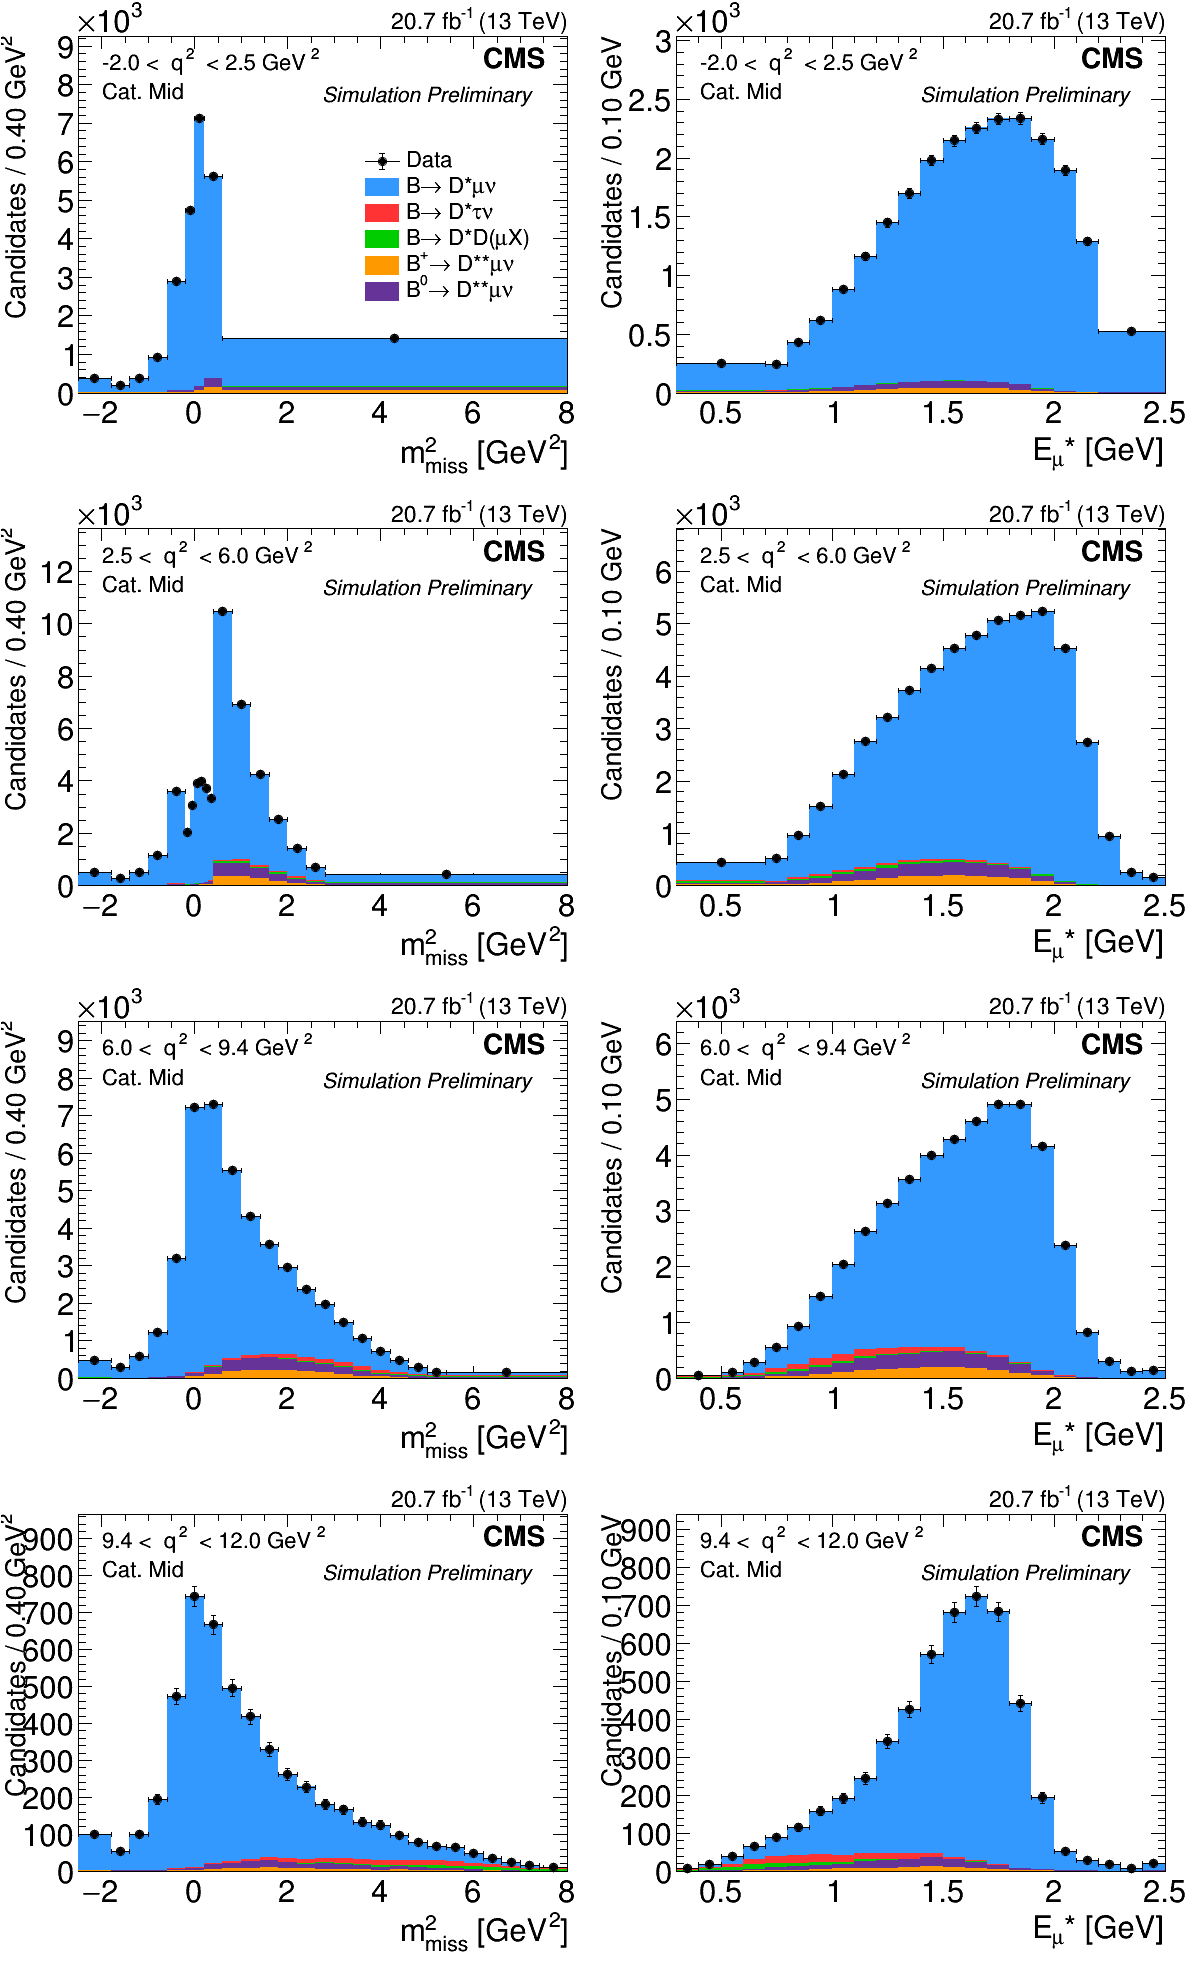

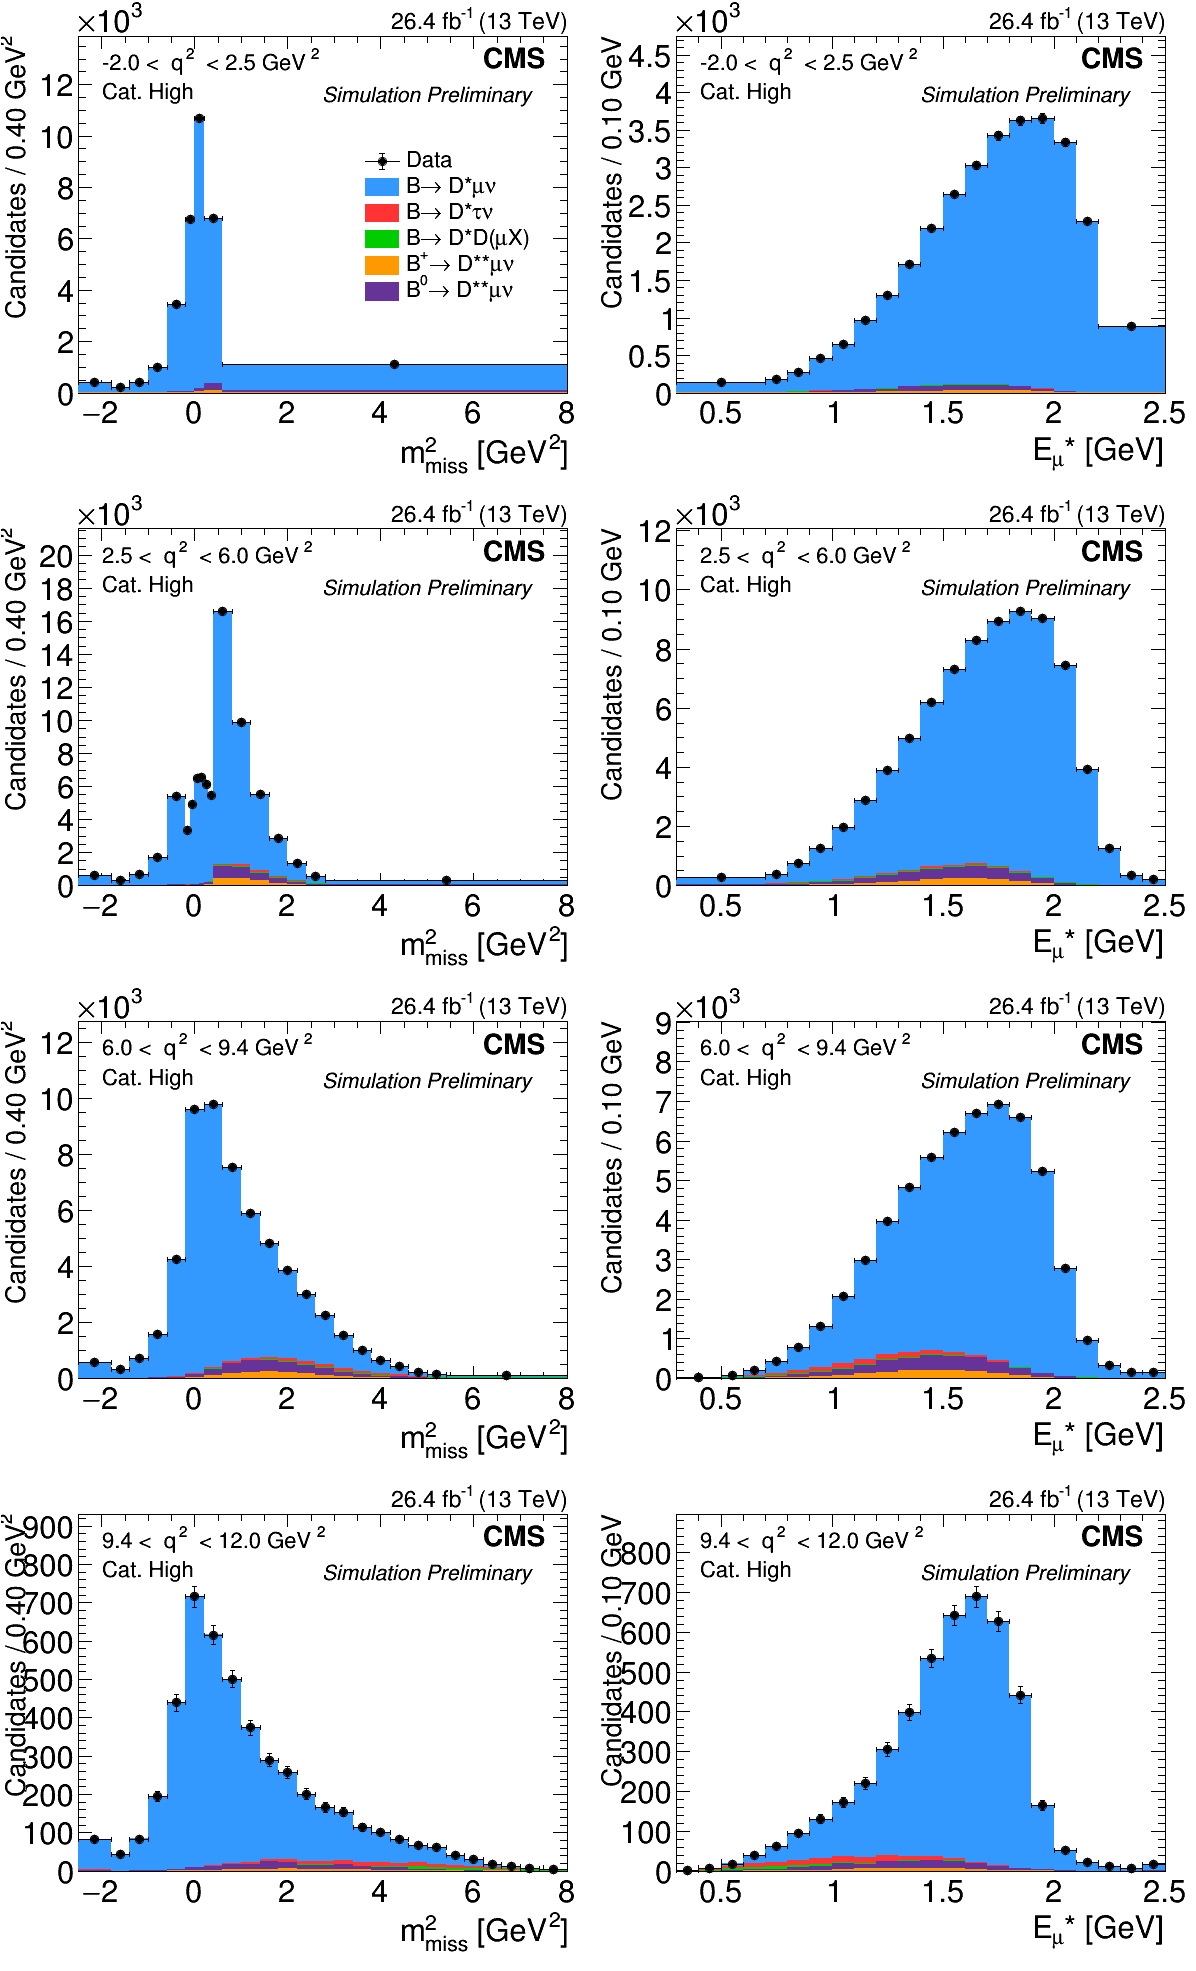

In [15]:
cSigPre = {}
scale_dic = {'tau': SM_RDst}
for c in categoriesList:
    CMS_lumi.integrated_lumi = expectedLumi[c]
    cSigPre[c] = plot_gridVarQ2(CMS_lumi, binning, histo[c], 
                                scale_dic=scale_dic, min_y=0, logy=False, 
                                categoryText=c.capitalize())
    cSigPre[c].SaveAs(outdir + '/fig/preFit_signalRegion_{}.png'.format(c))

In [16]:
def getControlXtitle(k):
    if 'mVis' in k:
        return 'Total visible mass'
    if 'mHad' in k:
        return 'Total hadrons mass'
    else:
        raise
        
def getControlSideText(k):
    aux = k.split('_')[1]
    t = 'N = '+str(len(aux))+' & Q = '
    Q = 0
    for q in aux:
        if q == 'm': Q -= 1
        elif q == 'p': Q += 1
        else: raise
    return t + str(Q)

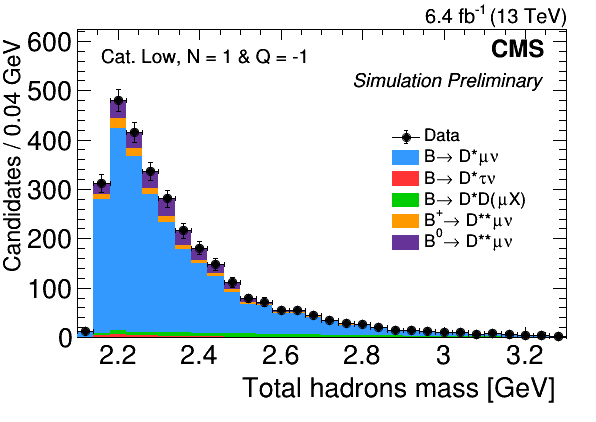

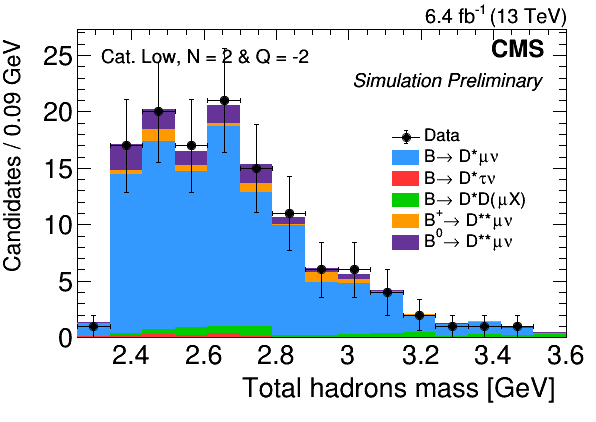

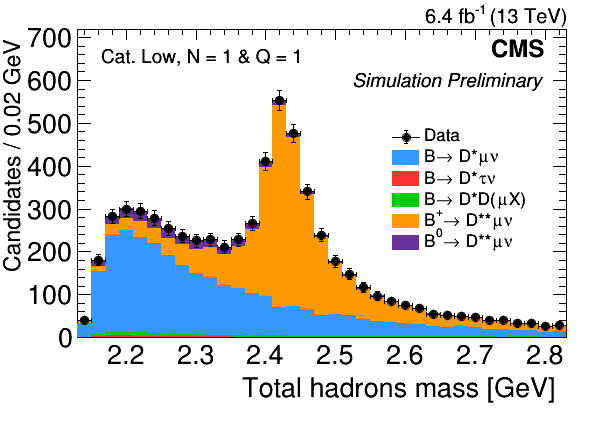

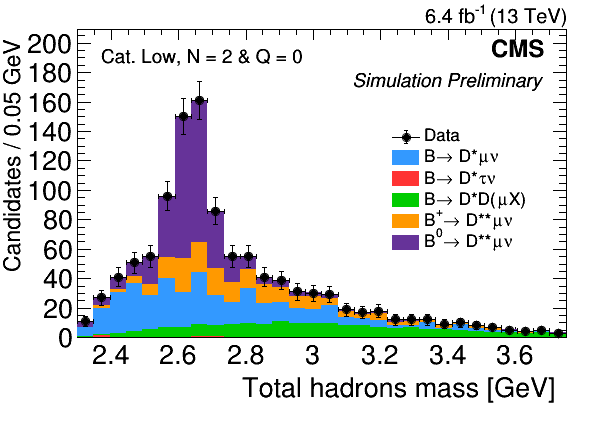

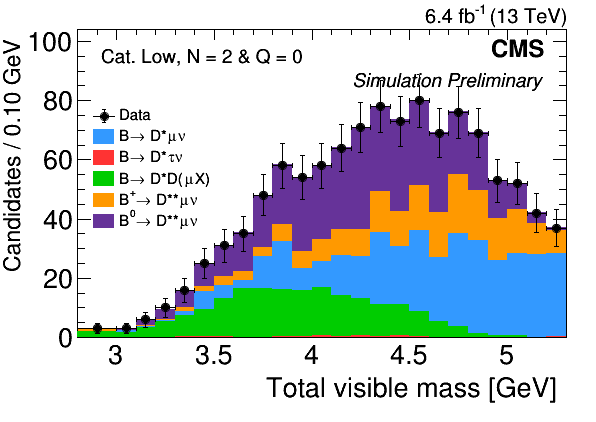

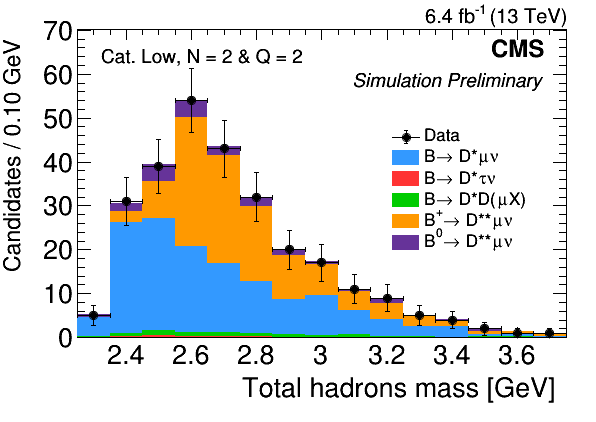

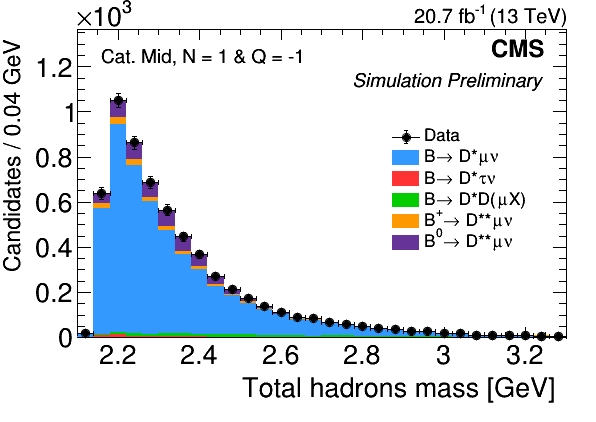

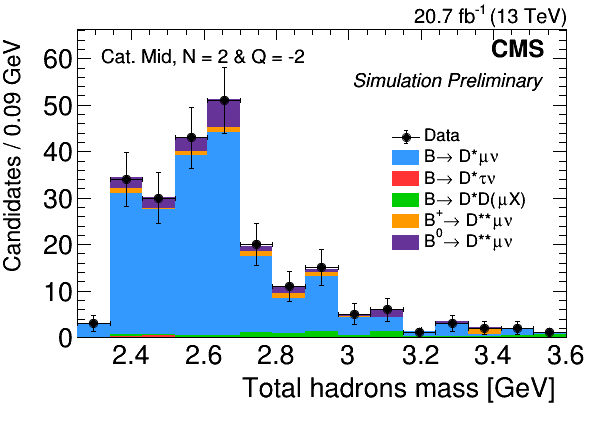

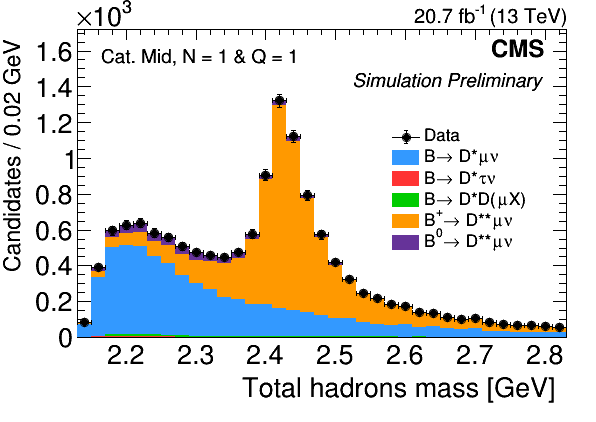

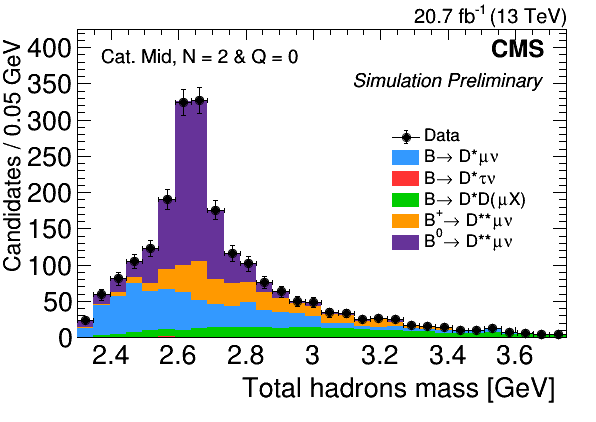

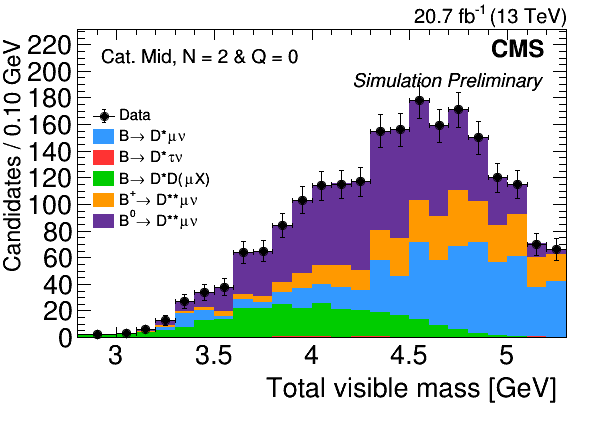

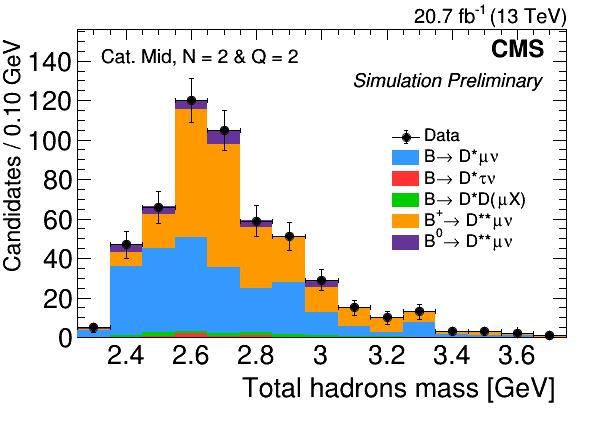

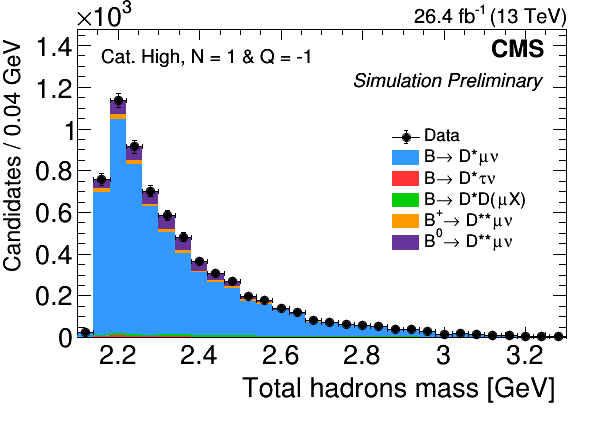

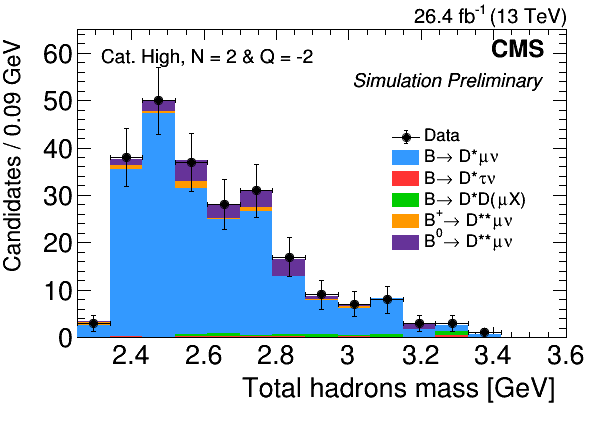

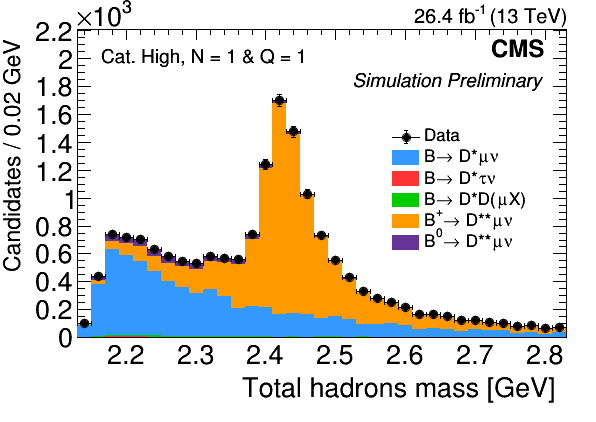

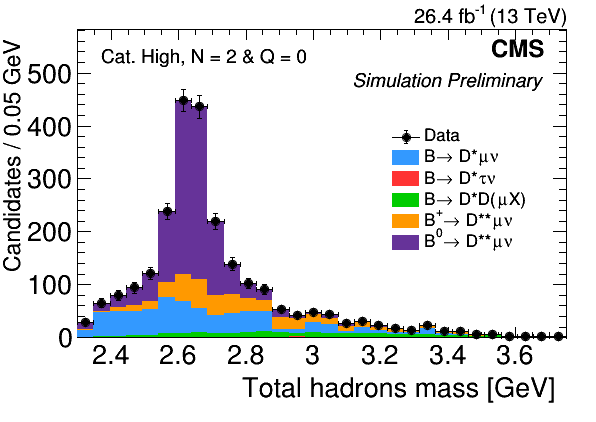

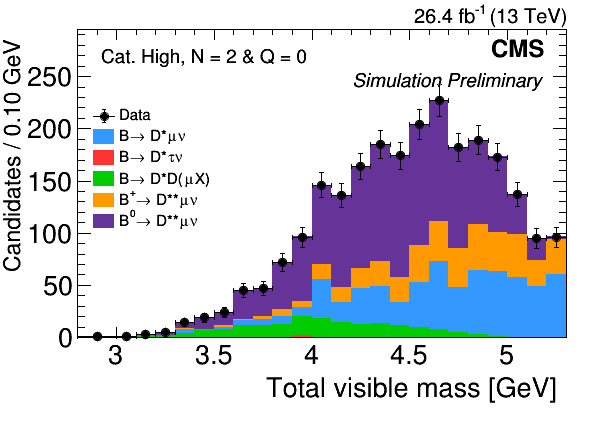

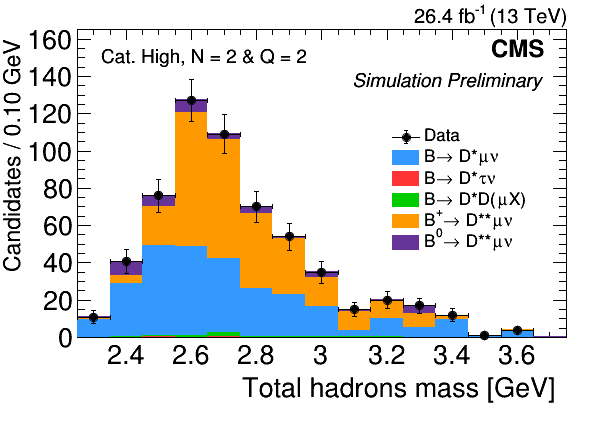

In [17]:
cSidePre = {}
for c in categoriesList:
    cSidePre[c] = {}
    CMS_lumi.integrated_lumi = expectedLumi[c]
    for k in np.sort([k for k in histo[c].keys() if k.startswith('Add')]):
        legLoc = [0.65, 0.4, 0.9, 0.7]
        if 'mVis' in k:
            legLoc = [0.15, 0.45, 0.35, 0.75]
        cSidePre[c][k] = plot_SingleCategory(CMS_lumi, histo[c][k], scale_dic=scale_dic,
                                             xtitle=getControlXtitle(k), 
                                             addText='Cat. '+c.capitalize() + ', ' + getControlSideText(k), 
                                             min_y=0, tag=c+k, legLoc=legLoc)
        cSidePre[c][k].SaveAs(outdir + '/fig/preFit_{}_{}.png'.format(k, c))        

# Run Combine

In [18]:
if not runCombine:
    raise

## Run the Maximum Likelyhood fit

In [19]:
seedMLf = '6741'

In [20]:
cmd = 'combine -M FitDiagnostics'
cmd += ' --robustFit 1 --robustHesse 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic'
cmd += ' --skipBOnlyFit'
cmd += ' --seed ' + seedMLf
cmd += ' -d ' + card_location.replace('.txt', '.root')
# cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.01,5'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties --saveNormalizations'
cmd += ' --plots'
cmd += ' --verbose 1'

print cmd
status, output = commands.getstatusoutput(cmd)
for line in output.split('\n'):
        if 'ERROR' in line: print line.replace('ERROR', '\033[1m\x1b[31mError\x1b[0m')
os.system('mv combine_logger.out ' + outdir + '/combine_logger_FitDiagnostics.out')
os.system('mv ./higgsCombine{}.FitDiagnostics.mH120.{}.root '.format(card_name, seedMLf) + outdir + '/');

combine -M FitDiagnostics --robustFit 1 --robustHesse 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic --skipBOnlyFit --seed 6741 -d cards/combinationAsimov_v0.root --setParameters r=0.33 --setParameterRanges r=0.01,5 -n combinationAsimov_v0 --out results/combinationAsimov_v0 --saveShapes --saveWithUncertainties --saveNormalizations --plots --verbose 1
Messages of type Error : 0


mv: cannot stat 'combine_logger.out': No such file or directory


In [21]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.{}.root'.format(card_name, seedMLf))[0])
c, d, u, _ = f['limit']['limit'].array()
print 'R(D*) = {:.3f} +{:.3f}/-{:.3f} [{:.1f} %]'.format(c, u-c, c-d, 100*(u-d)*0.5/c)
rDst_postFitRegion = [max(0.01,c - 5*(c-d)), min(c + 5*(u-c), 0.9)]

R(D*) = 0.331 +4.669/-0.321 [753.8 %]


In [22]:
# Get post-fit shapes
fFitDiagnostics = rt.TFile.Open(outdir + '/fitDiagnostics{}.root'.format(card_name), 'READ')
fd = fFitDiagnostics.shapes_fit_s

histo_postfit = {}
for c in categoriesList:
    histo_postfit[c] = {}
    for cat, h_dic in histo[c].iteritems():
        histo_postfit[c][cat] = {}
        for n, h in h_dic.iteritems():
            if '__' in n:
                continue
            h_post = h.Clone(h.GetName() + '_postfit')
            if 'data' in n:
                h_fit = fd.Get(c+'_'+cat+'/total')
                h_data = h.Clone(h.GetName() + '_data')
                for i in range(1, h_post.GetNbinsX()+1):
                    h_post.SetBinContent(i, h_fit.GetBinContent(i))
                    h_post.SetBinError(i, h_fit.GetBinError(i))     

                histo_postfit[c][cat]['total'] = h_post
                histo_postfit[c][cat][n] = h_data
            else:
                h_fit = fd.Get(c+'_'+cat+'/'+n)
                if not h_fit: 
                    print n+' missing from '+c+' '+cat
                    continue
                for i in range(1, h_post.GetNbinsX()+1):
                    h_post.SetBinContent(i, h_fit.GetBinContent(i))
                    h_post.SetBinError(i, h_fit.GetBinError(i)) 

                histo_postfit[c][cat][n] = h_post

BmDstmHc missing from low AddTk_pp_mHad
BmDstmHc missing from mid AddTk_pp_mHad
BpDstmHc missing from high AddTk_mm_mHad


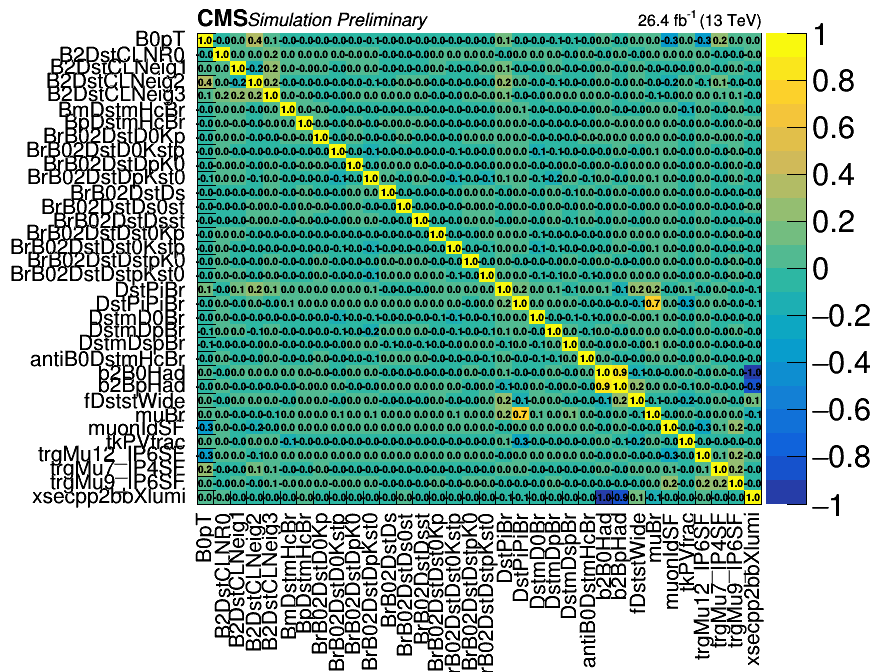

In [23]:
h2 = fFitDiagnostics.Get('covariance_fit_s')
rt.gStyle.SetPaintTextFormat('.1f')

N = h2.GetNbinsX()
n=34

h2.GetXaxis().SetRange(1, n)
h2.GetYaxis().SetRangeUser(N-n, N)
h2.SetMarkerSize(.8)
h2.LabelsOption("v")
CC = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'text same'], size=(900, 700), tag='tl', mL=0.22, mR=0.15, mB=0.25)
CC.SaveAs(outdir+'/fig/covariance_zoom.png')

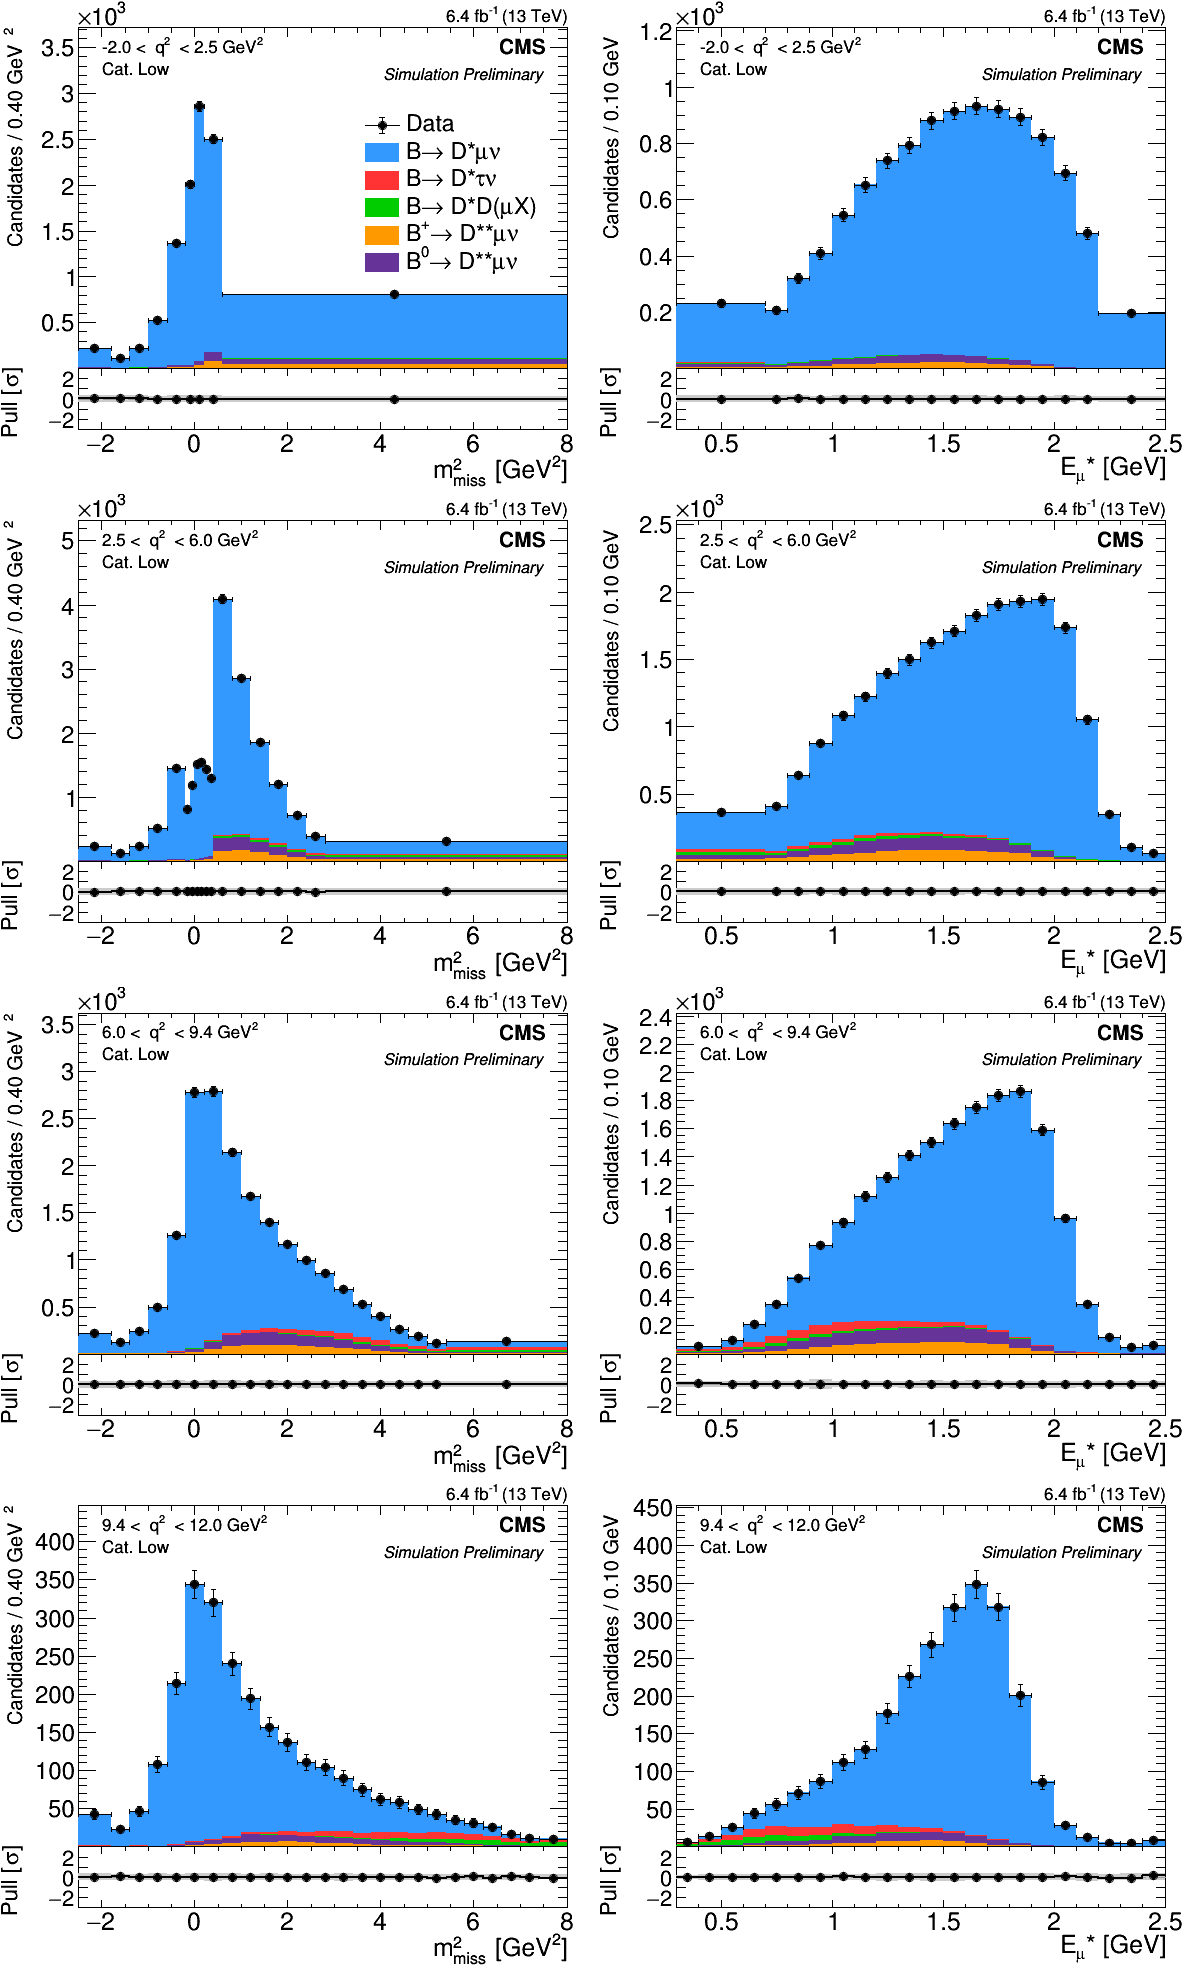

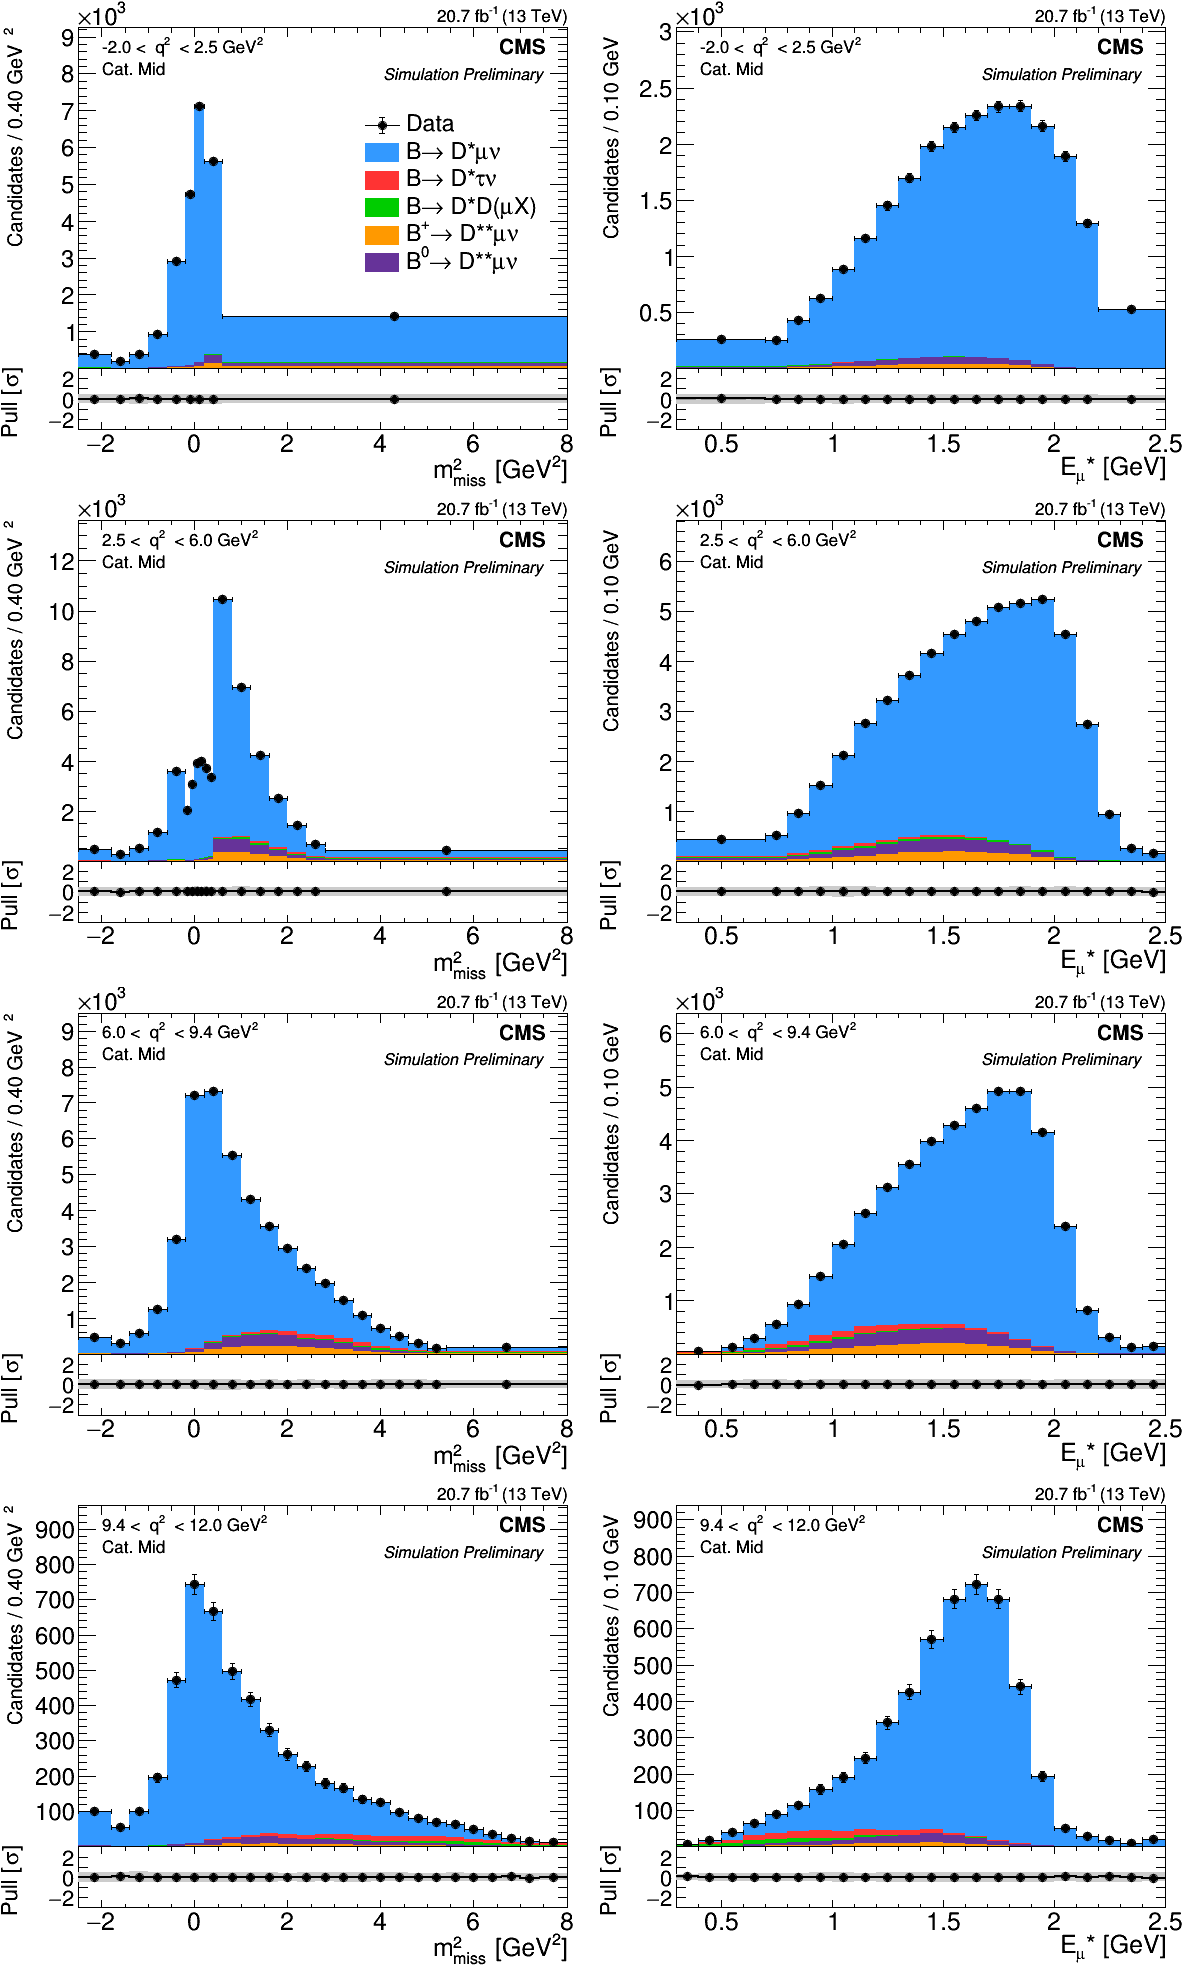

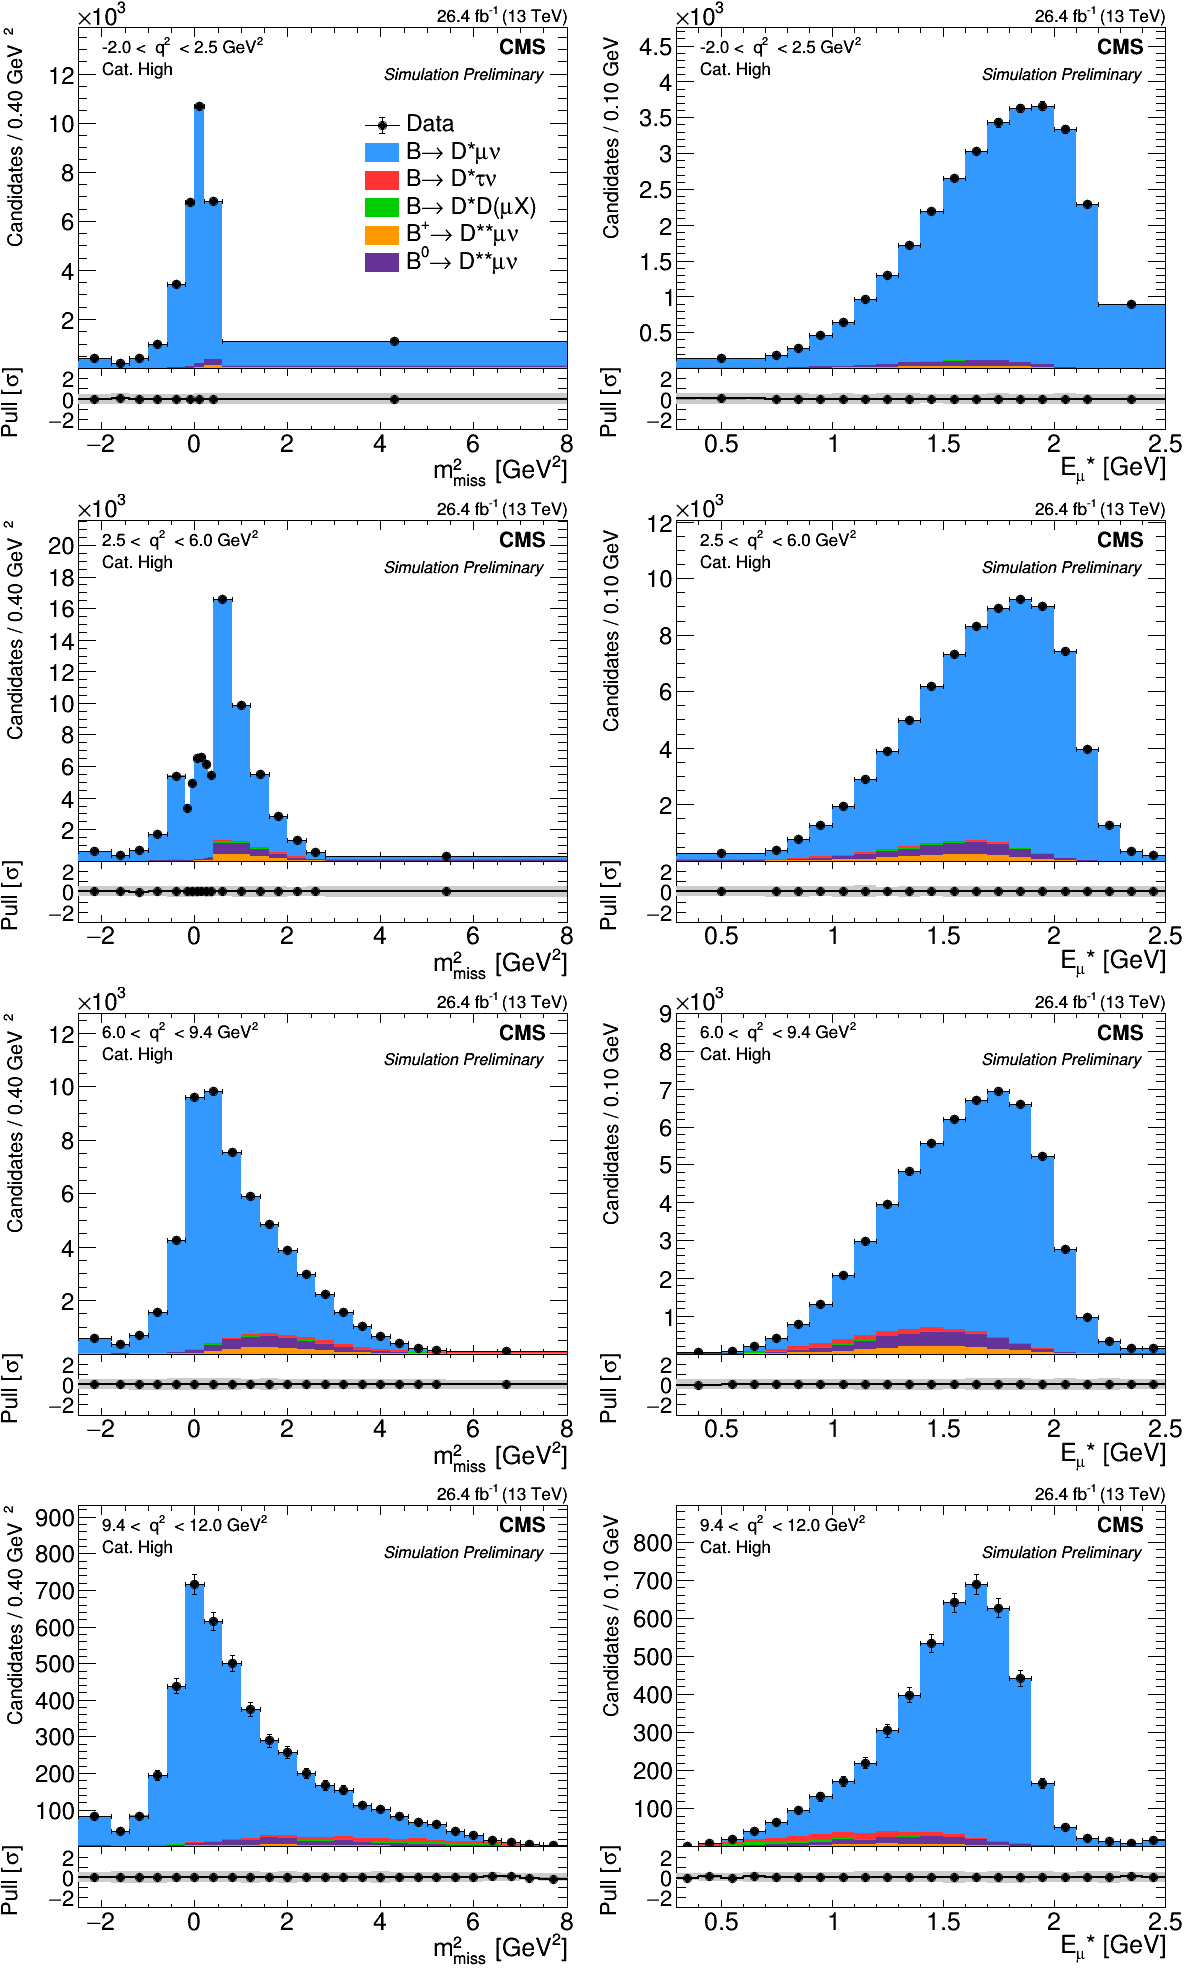

In [24]:
cSigPost = {}
for c in categoriesList:
    CMS_lumi.integrated_lumi = expectedLumi[c]
    cSigPost[c] = plot_gridVarQ2(CMS_lumi, binning, histo_postfit[c], 
                                 draw_pulls=True, categoryText=c.capitalize())
    cSigPost[c].SaveAs(outdir + '/fig/postFit_signalRegion_{}.png'.format(c))

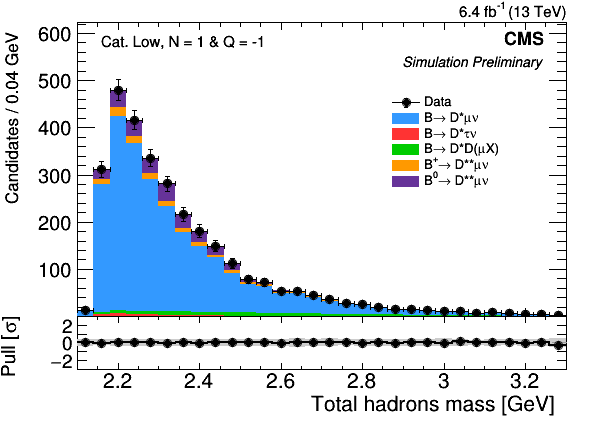

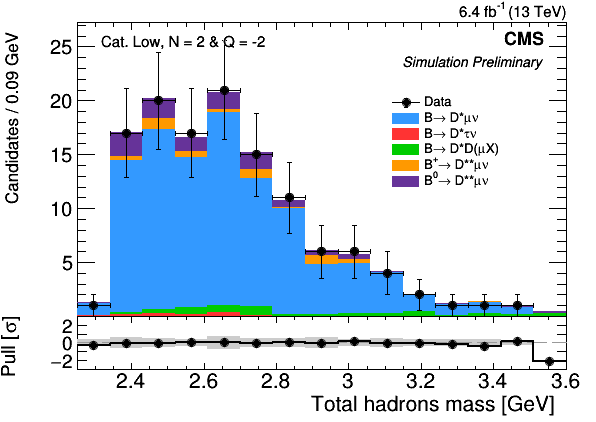

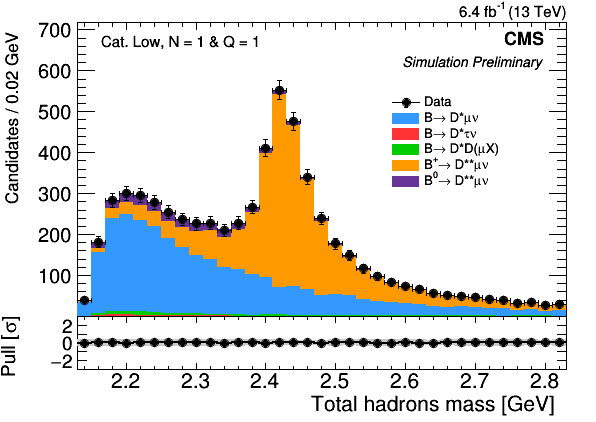

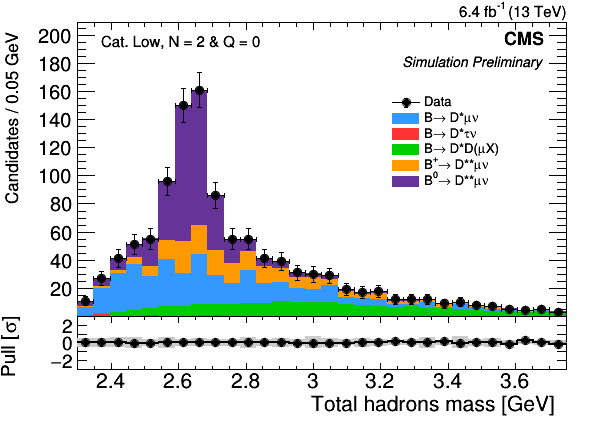

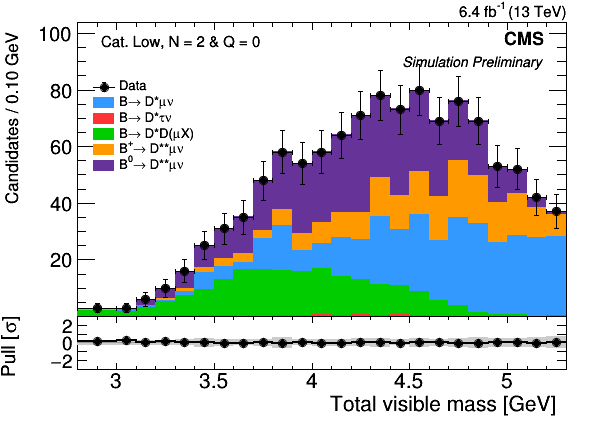

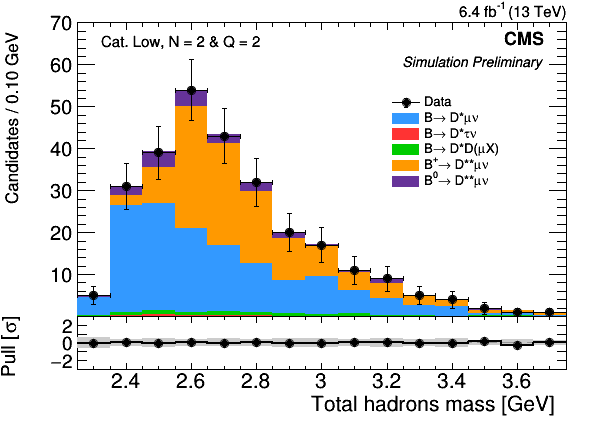

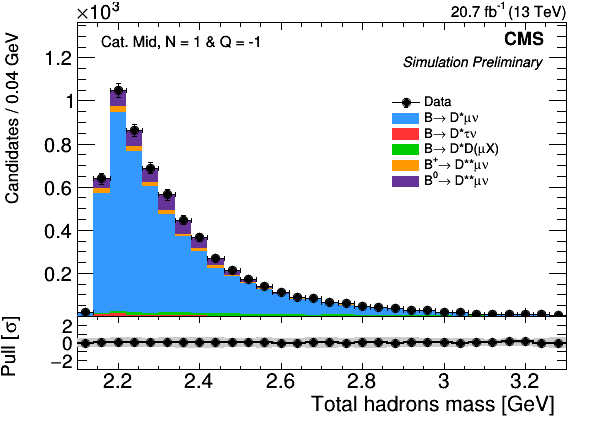

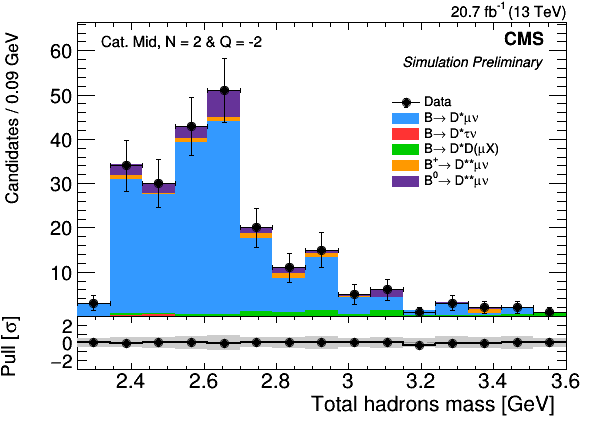

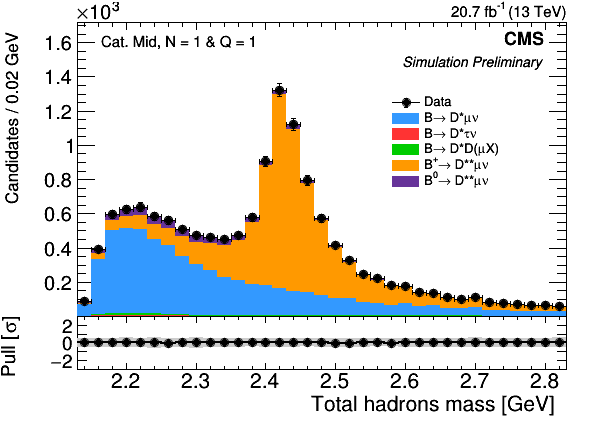

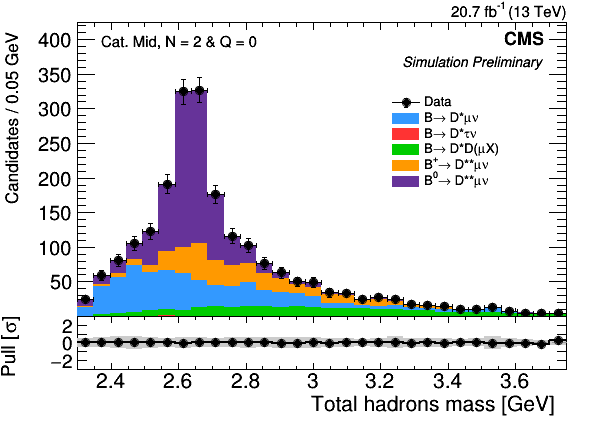

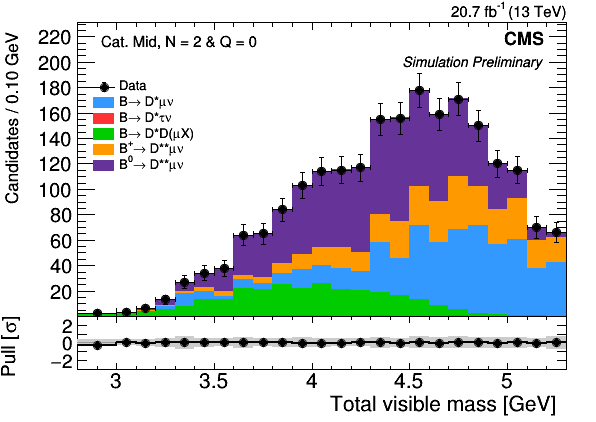

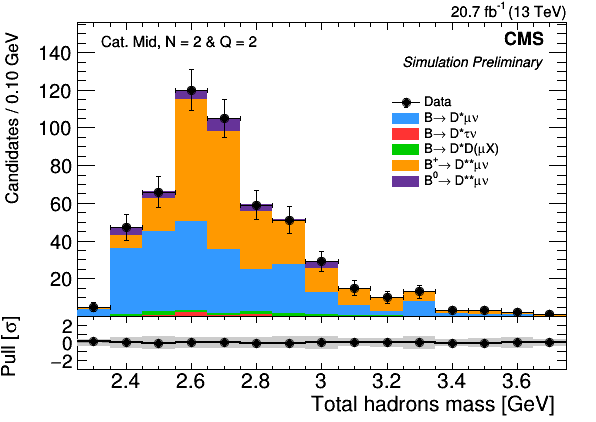

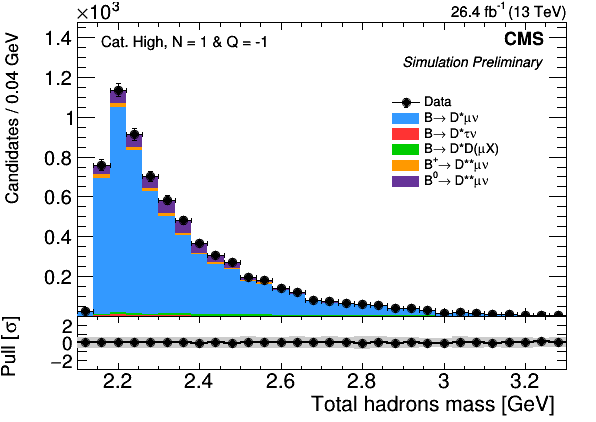

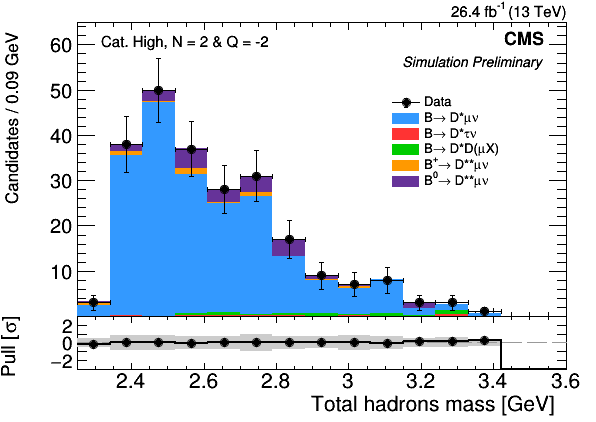

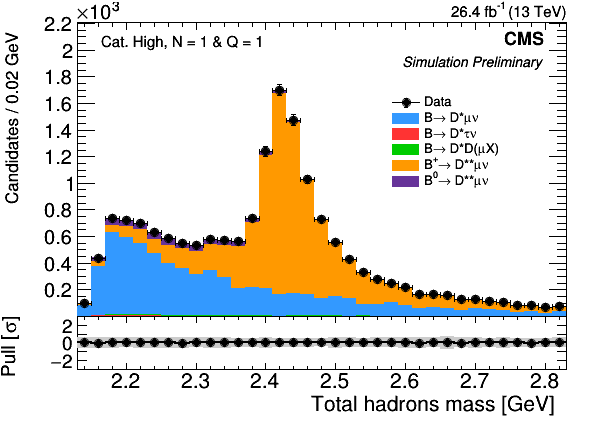

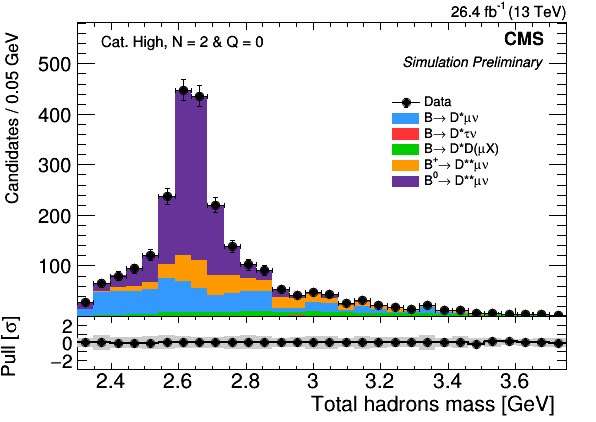

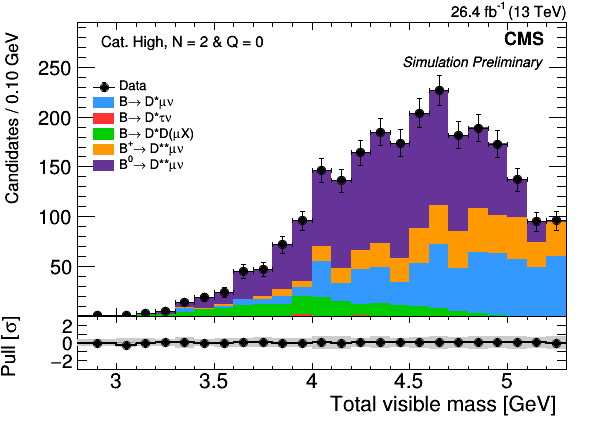

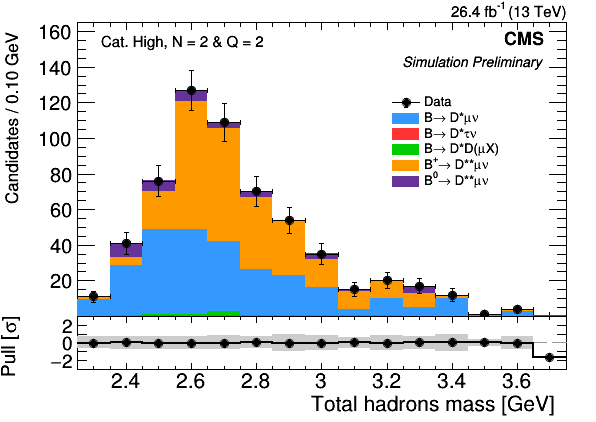

In [25]:
cSidePost = {}
for c in categoriesList:
    cSidePost[c] = {}
    CMS_lumi.integrated_lumi = expectedLumi[c]
    for k in np.sort([k for k in histo_postfit[c].keys() if k.startswith('Add')]):
        legLoc = [0.65, 0.4, 0.9, 0.7]
        if 'mVis' in k:
            legLoc = [0.15, 0.45, 0.35, 0.75]
        cSidePost[c][k] = plot_SingleCategory(CMS_lumi, histo_postfit[c][k],
                                              xtitle=getControlXtitle(k), 
                                              addText='Cat. '+c.capitalize() + ', ' + getControlSideText(k), 
                                              tag=c+k, legLoc=legLoc,
                                              draw_pulls=True
                                             )
        cSidePost[c][k].SaveAs(outdir + '/fig/postFit_{}_{}.png'.format(k, c))   

In [26]:
cmd = 'python diffNuisances.py '.format(os.environ['CMSSW_BASE'])
cmd += outdir + '/fitDiagnostics{}.root'.format(card_name)
cmd += ' --skipFitB'
# cmd += ' --all'
cmd += ' --abs'
cmd += ' -g {}/nuisance_difference.root'.format(outdir)
print cmd
status, output = commands.getstatusoutput(cmd)
dumpDiffNuisances(output, outdir)

python diffNuisances.py results/combinationAsimov_v0/fitDiagnosticscombinationAsimov_v0.root --skipFitB --abs -g results/combinationAsimov_v0/nuisance_difference.root
+-----------------------------------------+------------------------+---------------------------------+
|                Parameter                |        pre-fit         |             post-fit            |
+-----------------------------------------+------------------------+---------------------------------+
| prop_binhigh_AddTk_pp_mHad_bin14_DstPi0 | 1.000000 +/- 0.994425  | +0.77 +/- 0.77 (-0.23sig, 0.77) |
| prop_binhigh_AddTk_pp_mHad_bin14_DstPip | 1.000000 +/- 0.994425  | +0.87 +/- 0.86 (-0.13sig, 0.87) |
|     prop_binhigh_AddTk_mm_mHad_bin11    |  0.000000 +/- 1.000000 | +0.13 +/- 0.82 (+0.13sig, 0.82) |
|     prop_binhigh_AddTk_mm_mHad_bin0     | 0.000000 +/- 1.000000  | -0.11 +/- 0.89 (-0.11sig, 0.89) |
|    prop_binmid_AddTk_mm_mHad_bin11_mu   |  3.000000 +/- 1.723437 | +2.82 +/- 1.25 (-0.10sig, 0.73) |
|    prop

## Run likelyhood scan

combine -M MultiDimFit --algo grid --points=50 --robustFit 1 -d cards/combinationAsimov_v0.root --X-rtd MINIMIZER_analytic --rMin=0.0100 --rMax=0.9000 -n combinationAsimov_v0_nominal --verbose -1
----------------------------------
R(D*) = 0.329 +0.035/-0.035 [10.6 %]
Sigma = 0.035
----------------------------------



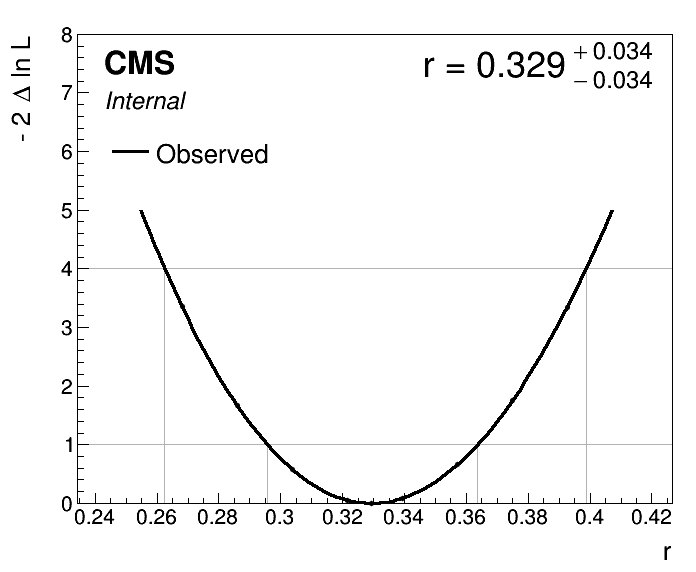

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 2.23 min (cpu), 2.23 min (real)
--------------------------------------
scan
--------------------------------------
[{'lo': 0.29568232167300895, 'hi': 0.36371315979286417, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2625040417138625, 'hi': 0.3987418638172972, 'valid_hi': True, 'valid_lo': True}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [27]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=50'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
# cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_nominal'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd)
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += '; mv scan.png scan_nominal.png'
os.system(cmd)
res_nominal = getUncertaintyFromLimitTree('higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name))
display(Image(filename='scan_nominal.png'))

### Uncertainy breakdown by group

In [28]:
cmd = 'combine -M MultiDimFit --algo none'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}_bestfit'.format(card_name)
cmd += ' --saveWorkspace --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo none --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d cards/combinationAsimov_v0.root --setParameters r=0.33 --setParameterRanges r=0.001,1 -n combinationAsimov_v0_bestfit --saveWorkspace --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
   r :    +0.329
Done in 0.07 min (cpu), 0.07 min (real)


In [29]:
# Statistical uncertainty
cmd = 'combine -M MultiDimFit --algo grid --points=50'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_stat'.format(card_name)
cmd += ' --freezeParameters allConstrainedNuisances'
# cmd += ' --freezeNuisanceGroups=autoMCStats,allSys'
cmd += ' --fastScan' # To be added if there are no free parameters otherwise
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=50 --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinecombinationAsimov_v0_bestfit.MultiDimFit.mH120.root --snapshotName MultiDimFit --rMin=0.0100 --rMax=0.9000 -n combinationAsimov_v0_stat --freezeParameters allConstrainedNuisances --fastScan --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Done in 0.04 min (cpu), 0.04 min (real)


In [30]:
# MC Statistics
cmd = 'combine -M MultiDimFit --algo grid --points=50'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_MCstat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=50 --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinecombinationAsimov_v0_bestfit.MultiDimFit.mH120.root --rMin=0.0100 --rMax=0.9000 -n combinationAsimov_v0_MCstat --snapshotName MultiDimFit --freezeNuisanceGroups=autoMCStats --verbose -1
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
Done in 1.37 min (cpu), 1.37 min (real)


plot1DScan.py higgsCombinecombinationAsimov_v0_nominal.MultiDimFit.mH120.root --others "higgsCombinecombinationAsimov_v0_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4" "higgsCombinecombinationAsimov_v0_stat.MultiDimFit.mH120.root:Freeze all:2" --breakdown MCstat,syst,stat --translate results/combinationAsimov_v0/renameDicLikelihoodScan.json; mv scan.png scan_breakdown.png


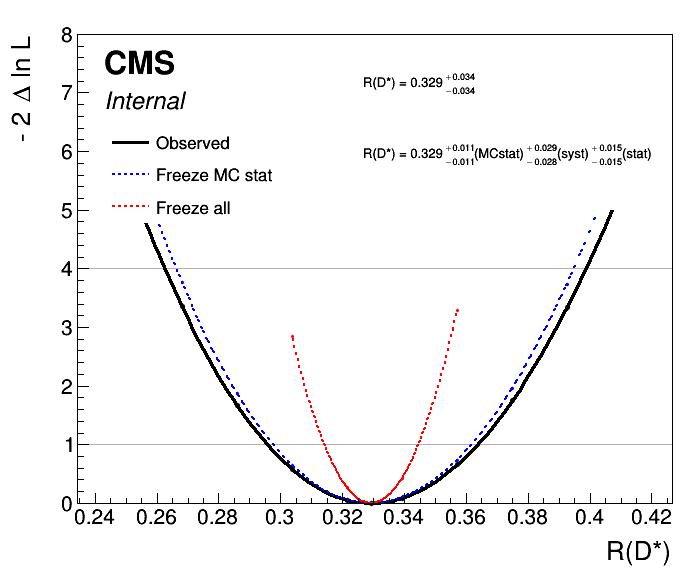

--------------------------------------
scan
--------------------------------------
[{'lo': 0.29568232167300895, 'hi': 0.36371315979286417, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2625040417138625, 'hi': 0.3987418638172972, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2975536094996033, 'hi': 0.3618106105644335, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.26623359487690024, 'hi': 0.3948974677591862, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.31415765744900137, 'hi': 0.3446636529090275, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.3037000000476837, 'hi': 0.3570999801158905, 'valid_hi': False, 'valid_lo': False}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [31]:
json.dump({'r': 'R(D*)'}, open(outdir+'/renameDicLikelihoodScan.json', 'w'))

cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --others'
cmd += ' "higgsCombine{}_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4"'.format(card_name)
cmd += ' "higgsCombine{}_stat.MultiDimFit.mH120.root:Freeze all:2"'.format(card_name)
cmd += ' --breakdown MCstat,syst,stat'
cmd += ' --translate ' + outdir+'/renameDicLikelihoodScan.json'
cmd += '; mv scan.png scan_breakdown.png'
print cmd
os.system(cmd)
display(Image(filename='scan_breakdown.png'))

In [32]:
os.system('mv higgsCombine{}_*.MultiDimFit.mH120.root '.format(card_name) + outdir + '/')
os.system('mv scan* ' + outdir + '/')
os.system('mv combine_logger.out ' + outdir + '/');

## Run the impact plots

In [33]:
if not runImpacts:
    raise

Fit first the POI

In [34]:
os.mkdir(outdir+'/impactPlots')

In [35]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doInitialFit -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.01,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
os.system(cmd);

Have POIs: ['r']
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
   r :    +0.329   -0.034/+0.034 (68%)
Done in 0.86 min (cpu), 0.86 min (real)
>> combine -M MultiDimFit -n _initialFit_combinationAsimov_v0 --algo singles --redefineSignalPOIs r --robustFit 1 --X-rtd MINIMIZER_analytic --setParameterRanges r=0.01,1 --verbose -1 -m 120 -d ../../../cards/combinationAsimov_v0.root --setParameters r=0.33


 Perform a similar scan for each nuisance parameter

If running on Tier2 condor remmeber to add this line to CombineToolBase.py ln 11
``source /cvmfs/cms.cern.ch/cmsset_default.sh``

In [36]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doFits -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
# cmd += ' --parallel 20'
cmd += ' --parallel 100 --job-mode condor --task-name combineImpacts_combination'
cmd += ' --sub-opts "{}"'.format(stringJubCustomizationCaltechT2.replace('"', '\\\"').replace('$', '\$'))
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd);

cd results/combinationAsimov_v0/impactPlots; combineTool.py -M Impacts --doFits -m 120 --robustFit 1 --X-rtd MINIMIZER_analytic --parallel 100 --job-mode condor --task-name combineImpacts_combination --sub-opts "
+RunAsOwner = True
+InteractiveUser = True
+SingularityImage = \"/cvmfs/singularity.opensciencegrid.org/cmssw/cms:rhel7-m20200605\"
+SingularityBindCVMFS = True
+MaxRuntime = 3600
RequestDisk = 200000
RequestMemory = 2500
RequestCpus = 1
x509userproxy = \$ENV(X509_USER_PROXY)
" -d ../../../cards/combinationAsimov_v0.root -n combinationAsimov_v0 --verbose -1
Submitting job(s)..........................................................................................................................................................................................................................................................................................................................................................................................................................

Collect the results

In [37]:
status, output = commands.getstatusoutput('condor_q')
while 'combineImpacts_combination' in output:
    time.sleep(20)
    status, output = commands.getstatusoutput('condor_q')
    for l in output.split('\n'):
        if 'combineImpacts_combination' in l: 
            print l
            sys.stdout.flush()
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts -o impacts.json -m 120'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
print cmd
os.system(cmd);

ocerri combineImpacts_combination   8/11 11:46      _    824    143    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46      _    824    143    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46      _    824    143    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46      3    824    140    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46     15    824    128    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46     31    824    112    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46     74    824     69    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46    199    768      _    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46    468    499      _    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46    722    245      _    967 198494.0-966
ocerri combineImpacts_combination   8/11 11:46    848    119      _    967 198494.0-966
ocerri combineImpacts_combinatio

In [38]:
rename = {
'r': 'R(D*)',
'B0pT': 'B_{0} p_{T} spectrum',
'B2DstCLNR0':'R_{0} (CLN B#rightarrow D*#ell#nu)',
'B2DstCLNeig1':'#lambda_{1} (CLN B#rightarrow D*l#nu)',
'B2DstCLNeig2':'#lambda_{2} (CLN B#rightarrow D*l#nu)',
'B2DstCLNeig3':'#lambda_{3} (CLN B#rightarrow D*l#nu)',
# 'B2DstCLNR1':'R_{1} (CLN B#rightarrow D*)',
# 'B2DstCLNR2':'R_{2} (CLN B#rightarrow D*)',
# 'B2DstCLNRhoSq':'#rho^{2} (CLN B#rightarrow D*)',
'trgSF': 'Trigger scale factor',
'xsecpp2bbXlumi': 'Luminosity*#sigma_{pp#rightarrowbb}',
    
}

procName_dic = {
'mu'        : 'B_{0}#rightarrow D*#mu#nu',
'tau'       : 'B_{0}#rightarrow D*#tau#nu',
'DstmD0'    : 'B^{+}#rightarrow D*D_{0}(#muY) + X',
'DstmDp'    : 'B^{+}#rightarrow D*D^{+}(#muY) + X',
'DstmDsp'   : 'B^{+}#rightarrow D*D_{s}^{+}(#muX)',
'DstPip'    : 'B^{+}#rightarrow D*#pi^{+}#mu#nu',
'DstPipPi0' : 'B^{+}#rightarrow D*#pi^{+}#pi^{0}#mu#nu',
'DstPi0'    : 'B_{0}#rightarrow D*#pi^{0}#mu#nu',
'DstPipPim' : 'B_{0}#rightarrow D*#pi^{+}#pi^{-}#mu#nu',
'DstPi0Pi0' : 'B_{0}#rightarrow D*#pi^{0}#pi^{0}#mu#nu',
'BpDstmHc'  : 'B^{+}#rightarrow D*D(#muX)',
'BmDstmHc'  : 'B^{-}#rightarrow D*D(#muX)',
'antiB0DstmHc'  : '#bar{B}_{0}#rightarrow D*D(#muX)',
'DstPi'     : 'B #rightarrow D**(#rightarrow D*#pi)#mu#nu',
'DstPiPi'   : 'B #rightarrow D**(#rightarrow D*#pi#pi)#mu#nu', 
}

for n in procName_dic:
    rename[n+'Br'] = 'Branching fraction ' + procName_dic[n]

d = json.load(open(outdir+'/impactPlots/impacts.json', 'r'))
for par in d['params']:
    name = str(par['name'])
    if not name.startswith('prop_bin'): continue
    label = name.replace('prop_bin', 'MC stat. ')
    label = label.replace('M2_miss_', 'M^{2}_{miss} ')
    label = label.replace('Est_mu_', 'E*_{#mu} ')
    label = label.replace('q2bin', '[b_{q^{2}}=')
    label = label.replace('_bin', '] ')
    rename[name] = label + 10*' '
    
json.dump(rename, open(outdir+'/impactPlots/rename.json', 'w'))

cmd = 'cd {};'.format(outdir)
cmd += 'plotImpacts.py -i impactPlots/impacts.json -o impacts -t impactPlots/rename.json'
os.system(cmd)
IFrame(outdir+'/impacts.pdf', width=900, height=600)

>> Doing page 0, have 30 parameters
>> Doing page 1, have 30 parameters
>> Doing page 2, have 30 parameters
>> Doing page 3, have 30 parameters
>> Doing page 4, have 30 parameters
>> Doing page 5, have 30 parameters
>> Doing page 6, have 30 parameters
>> Doing page 7, have 30 parameters
>> Doing page 8, have 30 parameters
>> Doing page 9, have 30 parameters
>> Doing page 10, have 30 parameters
>> Doing page 11, have 30 parameters
>> Doing page 12, have 30 parameters
>> Doing page 13, have 30 parameters
>> Doing page 14, have 30 parameters
>> Doing page 15, have 30 parameters
>> Doing page 16, have 30 parameters
>> Doing page 17, have 30 parameters
>> Doing page 18, have 30 parameters
>> Doing page 19, have 30 parameters
>> Doing page 20, have 30 parameters
>> Doing page 21, have 30 parameters
>> Doing page 22, have 30 parameters
>> Doing page 23, have 30 parameters
>> Doing page 24, have 30 parameters
>> Doing page 25, have 30 parameters
>> Doing page 26, have 30 parameters
>> Doing pa

Info in <TCanvas::Print>: pdf file ./impacts.pdf has been created using the current canvas
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./imp

## Run the Goodness of fit test

Run the observed test stat value

In [39]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated'
cmd += ' --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0'
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s 1'                                      # Random seed
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
print cmd
os.system(cmd)

combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0 -d results/combinationAsimov_v0/higgsCombinecombinationAsimov_v0_bestfit.MultiDimFit.mH120.root --snapshotName MultiDimFit --bypassFrequentistFit -n Obs -t 0 -s 1 --setParameters r=0.33 --setParameterRanges r=0.001,1 --plots --verbose -1


0

 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 1
Set Range of Parameter r To : (0.001,1)
Set Default Value of Parameter r To : 0.33
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Enabling analytic minimisation of bin-wise statistical uncertainty parameters
>> Disabling analytic minimisation of bin-wise statistical uncertainty parameters

 --- GoodnessOfFit --- 
Best fit test statistic: 4.27241
Done in 0.13 min (cpu), 0.13 min (real)


Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/combinationAsimov_v0/higgsCombinecombinationAsimov_v0_bestfit.MultiDimFit.mH120.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
RooSimultaneousOpt: number of channel masks must equal number of channels


Run the test stat toy distribution

In [40]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated'
cmd += ' --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0'
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 30'                                     # Number of toys to run
cmd += ' -s -1'                                     # Random seed
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
cmdToys = cmd
print cmdToys
# os.system(cmdToys)

combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic --cminDefaultMinimizerStrategy 0 -d results/combinationAsimov_v0/higgsCombinecombinationAsimov_v0_bestfit.MultiDimFit.mH120.root --snapshotName MultiDimFit --bypassFrequentistFit -n Toys -t 30 -s -1 --setParameters r=0.33 --setParameterRanges r=0.001,1 --plots --verbose -1


In [41]:
from multiprocessing import Pool

def runCommand(cmd):
    os.system(cmd)

Nrep = 15
p = Pool(min(20,Nrep))
outputs = p.map(runCommand, Nrep*[cmdToys])

 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
 <<< Combine >>> 
 <<< Combine >>> 
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> method used is GoodnessOfFit
Will use saturated models to compute goodness of fit for a binned likelihood
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
Will use saturated models to 

Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/combinationAsimov_v0/higgsCombinecombinationAsimov_v0_bestfit.MultiDimFit.mH120.root
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/combinationAsimov_v0/higgsCombinecombinationAsimov_v0_bestfit.MultiDimFit.mH120.root
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/combinationAsimov_v0/higgsCombinecombinationAsimov_v0_bestfit.MultiDimFit.mH120.root
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/combinationAsimov_v0/higgsCombinecombinationAsimov_v0_bestfit.MultiDimFit.mH120.root
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file /storage/user/ocerri/BPhysics/Combine/results/combinationAsimov_v0/higgsCombinecombinationAsimov

In [42]:
os.system('mv *.root {}/'.format(outdir));

Combine them to get the p-value

In [43]:
plt.rcParams.update({'font.size': 18})

In [44]:
f = ur.open(outdir+'/higgsCombineObs.GoodnessOfFit.mH120.1.root')
s_obs = f['limit']['limit'].array()[0]

s_toys = []
for name_toys in glob(outdir+'/higgsCombineToys.GoodnessOfFit.*.root'):
    f = ur.open(name_toys)
    s_toys += list(f['limit']['limit'].array())
p_val = np.sum(s_toys > s_obs)/float(len(s_toys))
    
fig = plt.figure(figsize=(8,6))
content, center, _ = plt.hist(s_toys, weights=np.ones_like(s_toys)/float(len(s_toys)), 
                              alpha=0.7, label='Toys ({:.0f})'.format(float(len(s_toys))))
plt.plot([s_obs, s_obs], [0, np.max(content)], 'm--', label='Observed\np-val {:.1f}%'.format(100*p_val))
plt.legend(loc='upper right')
plt.xlabel('Test statistic')
plt.ylabel('Probability / {:.1f}'.format(0.5*(center[2]-center[1])))
plt.savefig(outdir + '/fig/goodnessOfFit_test.png')

ValueError: TKey declares that object '\x00' has 1919905652 bytes but only 407 remain in the file